# Download ADCP data from the AODN

This notebook includes

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map
from scipy import signal

from myspectra import filt_decompose

In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [3]:
# Login to the s3 bucket and list the deep water mooring (DWM) folders
fs = S3FileSystem(anon=True)
aodn = fs.ls('imos-data/IMOS/DWM/')
for item in aodn:
    print(item)

imos-data/IMOS/DWM/ASFS
imos-data/IMOS/DWM/DA
imos-data/IMOS/DWM/SOTS


In [4]:
def open_file_nocache(fname, myfs):
    """
    Load a netcdf file directly from an S3 bucket
    """
    fileobj = myfs.open(fname)
    return xr.open_dataset(fileobj)


In [5]:
# Find the aquadopp current meter mooring in one folder
aodn = fs.glob('imos-data/IMOS/DWM/SOTS/2021/*FV01*Aquadopp*.nc')
for item in aodn:
    print(item)

ncfile = aodn[0]

imos-data/IMOS/DWM/SOTS/2021/IMOS_DWM-SOTS_AETVZ_20210424_SAZ47_FV01_SAZ47-23-2021-Aquadopp-Current-Meter-AQD-9897-1200m_END-_C-20220530.nc


In [6]:
# Override the above
# EAC site
ncfile = 'imos-data/IMOS/DWM/DA/EAC4700/Velocity/IMOS_DWM-DA_AETVZ_20190916T083300Z_EAC4700_FV01_EAC4700-2021-Aquadopp-Current-Meter-985_END-20210517T212700Z_C-20211208T224818Z.nc'
# Plotting
t1,t2 = np.datetime64('2020-09-01'), np.datetime64('2020-11-01')
# Spectral estimation
t1s, t2s = '2019-10-01','2021-05-01'
sitename = 'EAC_1000m'

# # Southern Ocean
# ncfile = 'imos-data/IMOS/DWM/SOTS/2021/IMOS_DWM-SOTS_AETVZ_20210424_SAZ47_FV01_SAZ47-23-2021-Aquadopp-Current-Meter-AQD-9897-1200m_END-_C-20220530.nc'
# # Plotting
# t1,t2 = np.datetime64('2021-09-01'), np.datetime64('2021-11-01')
# # Spectral estimation
# t1s, t2s = '2021-05-01','2022-05-01'
# sitename = 'SO_1200m'

# Indonesian Throughflow
# ncfile = 'imos-data/IMOS/DWM/DA/ITFTSL/Velocity/IMOS_DWM-DA_ETVZ_20140410T020000Z_ITFTSL_FV01_ITFTSL-2014-AQUADOPP-CURRENT-METER-1189_END-20151025T225917Z_C-20160622T032641Z.nc'
# # Plotting
# t1,t2 = np.datetime64('2014-09-01'), np.datetime64('2014-11-01')
# # Spectral estimation
# t1s, t2s = '2014-05-01','2015-10-01'
# sitename = 'ITF_1200m'

#
ylims = -30, 30
velscale = 100. # Convert to cm

In [7]:
ds = open_file_nocache(ncfile, fs)
ds

<xarray.Dataset>
Dimensions:                   (TIME: 30010)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2019-09-01 ... 2021-05-18...
    LATITUDE                  float64 ...
    LONGITUDE                 float64 ...
    NOMINAL_DEPTH             float32 ...
Data variables: (12/33)
    TIMESERIES                int32 ...
    VCUR                      (TIME) float32 ...
    VCUR_quality_control      (TIME) float32 ...
    UCUR                      (TIME) float32 ...
    UCUR_quality_control      (TIME) float32 ...
    WCUR                      (TIME) float32 ...
    ...                        ...
    CSPD                      (TIME) float32 ...
    CSPD_quality_control      (TIME) float32 ...
    CDIR                      (TIME) float32 ...
    CDIR_quality_control      (TIME) float32 ...
    DEPTH                     (TIME) float32 ...
    DEPTH_quality_control     (TIME) float32 ...
Attributes: (12/55)
    abstract:                      The aim of the East Australian Current (EA...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Rebecca Cowley
    author_email:                  rebecca.cowley@csiro.au
    citation:                      The citation in a list of references is: "...
    comment:                       Geospatial vertical min/max information ha...
    ...                            ...
    time_deployment_end_origin:    TimeLastInPos
    time_deployment_start:         2019-09-16T08:33:00Z
    time_deployment_start_origin:  TimeFirstInPos
    title:                         Data collected from the 2019 to 2021 deplo...
    toolbox_input_file:            /oa-decadal-climate/work/observations/ocea...
    toolbox_version:               2.6.13 - GLNXA64

In [8]:
# Find the water depth
depth = ds.instrument_nominal_depth
#total_depth = ds.site_depth_at_deployment
depth

985.0

In [9]:
def get_vel_qc_aodn(ds,varname='UCUR'):
    """
    Function that returns the QC's variable
    (only works with FV01 of the IMOS convention)
    """
    badidx = ds['{}_quality_control'.format(varname)].values <2
    temp = ds['{}'.format(varname)]
    return temp.where(badidx, np.nan)


In [10]:
# Load velocity
u = get_vel_qc_aodn(ds, varname='UCUR')
v = get_vel_qc_aodn(ds, varname='VCUR')

u

<xarray.DataArray 'UCUR' (TIME: 30010)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * TIME           (TIME) datetime64[ns] 2019-09-01 ... 2021-05-18T04:31:17.0...
    LATITUDE       float64 -27.21
    LONGITUDE      float64 154.6
    NOMINAL_DEPTH  float32 985.0
Attributes:
    ancillary_variables:         UCUR_quality_control
    comment:                     magneticDeclinationPP: data initially referr...
    compass_correction_applied:  11.366666666666667
    long_name:                   eastward_sea_water_velocity
    magnetic_declination:        11.366666666666667
    reference_datum:             true north
    sensor_serial_number:        A6L-4891 (AQD 9872)
    standard_name:               eastward_sea_water_velocity
    units:                       m s-1
    valid_max:                   10.0
    valid_min:                   -10.0

In [11]:
# Calculate the Coriolis frequency
lat = ds.LATITUDE.values
f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
f_cpd = np.abs(f_coriolis*86400/(2*np.pi))
f_cpd, f_coriolis

(0.9144535303768865, -6.650093733984438e-05)

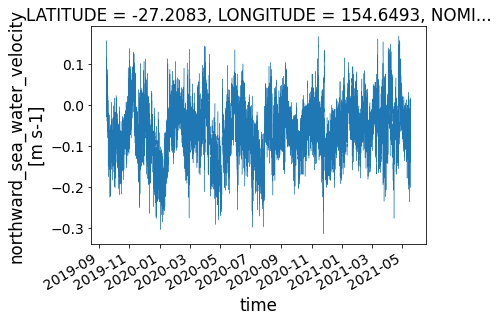

In [12]:
# Plot the whole time sseries
plt.figure()
v.plot(lw=0.4)

In [13]:
# Work out the sampling rate (seconds)
dt = (u.TIME[2]-u.TIME[1]).values.astype('float')/1e9
dt

1800.002558208

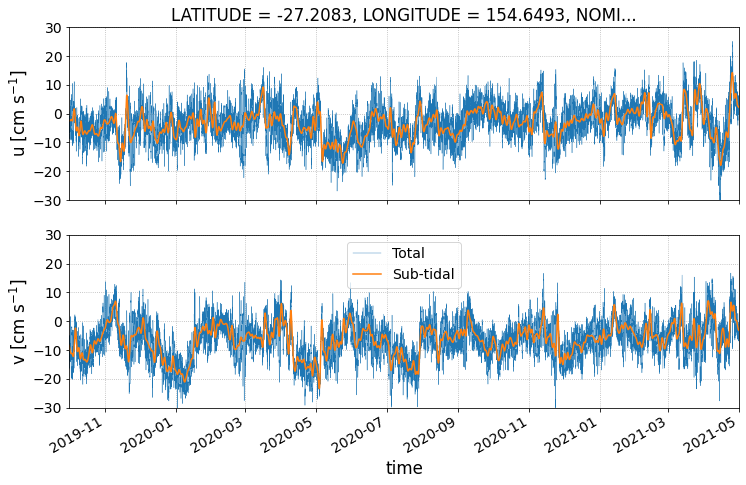

In [14]:
# Decompose the velocity into sub-tidal, tidal, and super-tidal by filtering
utmp = u.values*velscale
utmp[np.isnan(utmp)] = 0.
uf = filt_decompose(utmp, dt,low=60)

utmp = v.values*velscale
utmp[np.isnan(utmp)] = 0.
vf = filt_decompose(utmp, dt,low=60)

# PLot the filtered results over the raw data
plt.figure(figsize=(12,7))
ax=plt.subplot(211)
(u*velscale).plot(lw=0.4)
plt.plot(u.TIME, uf[:,0])
plt.ylim(ylims)
plt.xlim(u.TIME[0],u.TIME[-1])
plt.ylabel('u [cm s$^{-1}$]')
ax.set_xticklabels([])
plt.grid(b=True, ls=':')
plt.xlabel('')
plt.xlim(np.datetime64(t1s), np.datetime64(t2s))

ax=plt.subplot(212)
(v*velscale).plot(lw=0.4)
plt.plot(u.TIME, vf[:,0])
plt.ylim(ylims)
plt.xlim(u.TIME[0],u.TIME[-1])
plt.title('')
plt.ylabel('v [cm s$^{-1}$]')
plt.grid(b=True, ls=':')
plt.xlim(np.datetime64(t1s), np.datetime64(t2s))
plt.legend(('Total', 'Sub-tidal'))
plt.savefig('../FIGURES/{}_Currents.png'.format(sitename), dpi=150, )


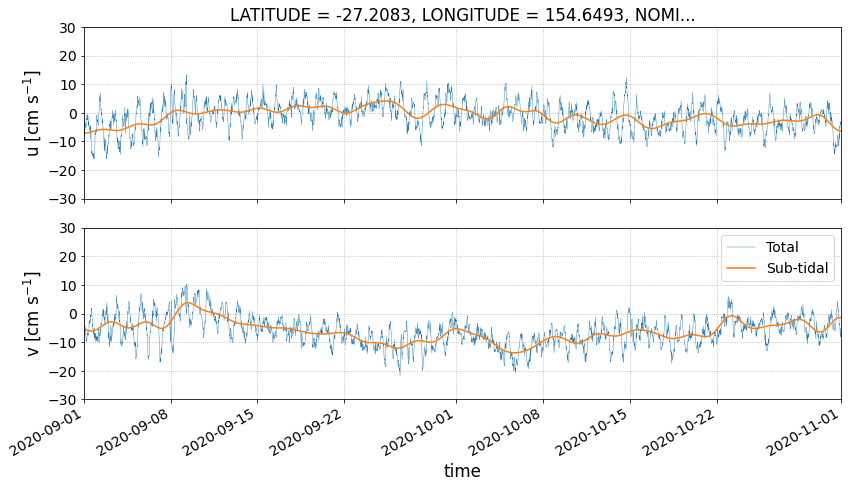

In [15]:
# Plot a smaller time range
plt.figure(figsize=(12,7))
ax=plt.subplot(211)
(u*velscale).plot(lw=0.4)
plt.plot(u.TIME, uf[:,0])
plt.ylim(ylims)
plt.xlim(t1,t2)
plt.ylabel('u [cm s$^{-1}$]')
ax.set_xticklabels([])
plt.grid(b=True, ls=':')
plt.xlabel('')

ax=plt.subplot(212)
(v*velscale).plot(lw=0.4)
plt.plot(u.TIME, vf[:,0])
plt.ylim(ylims)
plt.xlim(t1,t2)
plt.title('')
plt.ylabel('v [cm s$^{-1}$]')
plt.grid(b=True, ls=':')
plt.legend(('Total', 'Sub-tidal'))
plt.tight_layout()
plt.savefig('../FIGURES/{}_Currents_zoom.png'.format(sitename), dpi=150)

4096 (27792,)
Length of each segment [days]:  85.33345508465777
4096 (27792,) 0.011718733280023857 0.011718733280023857
42.62362 35.51265 1.2002376


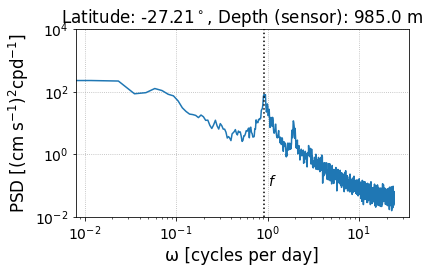

In [16]:
# Compute the power spectrum of the signal
nperseg = 2**12
u = u.sel(TIME=slice(t1s, t2s)) 
badidx = ~np.isnan(u)
time = u.TIME.values[badidx]
dt = (time[1]-time[0]).astype('float')/1e9
dt_days = dt/86400

y = u.values * velscale
f, Puu= signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

print(nperseg, y.shape)
print('Length of each segment [days]: ', nperseg*dt/86400)

# Check the scaling by comparing the signal variance to the integral under the power spectrum
df = f[1] - f[0]
print(nperseg, y.shape, df, np.mean(np.diff(f)))
print(np.var(y-y.mean()), np.trapz(Puu, dx=df), np.var(y)/np.trapz(Puu, dx=df))


plt.figure()
ax=plt.subplot(111)
plt.loglog(f, Puu,)

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(cm s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-2, 1e4)
ax.axvline(f_cpd, c='k', ls=':')
ax.text(f_cpd+0.1, 1e-1, '$f$')
plt.title('Latitude: {:3.2f}$^\circ$, Depth (sensor): {:3.1f} m'.format(lat, depth,))
plt.tight_layout()

plt.savefig('../FIGURES/{}_Currents_PSD.png'.format(sitename), dpi=150)
# \n Water Depth: {:3.1f} m total_depth

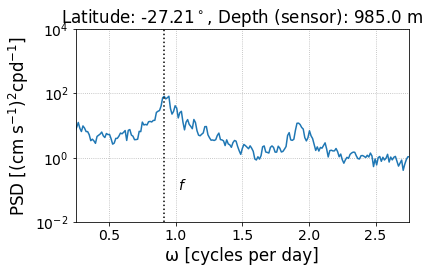

In [17]:
# Plot the spectrum in the tidal band only

plt.figure()
ax=plt.subplot(111)
plt.semilogy(f, Puu)
plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(cm s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-2, 1e4)
ax.axvline(f_cpd, c='k', ls=':')
ax.text(f_cpd+0.1, 1e-1, '$f$')
plt.title('Latitude: {:3.2f}$^\circ$, Depth (sensor): {:3.1f} m'.format(lat, depth,))
ax.set_xlim(0.25, 2.75)

plt.tight_layout()

plt.savefig('../FIGURES/{}_Currents_PSD_tidal.png'.format(sitename), dpi=150)
